<a href="https://colab.research.google.com/github/faouziMohamed/language-translation/blob/main/Neural_Machine_Translation(NMT).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here a exemple of preparing data to be fit in a Model of recurrent Neural Network

In [ ]:
import tensorflow as tf

# **Loading data**

## **Download and extraction of the dataset**

In [ ]:
import requests
dataset='en-fr.csv'
csv_filename= dataset

# Request and Download data from the given URL
data = requests.get("https://cra-acem.tech/dpl-project/dataset")

with open(dataset, 'wb') as dt:
  # Saving the dataset (writting the content in dataset csv files)
  dt.write(data.content)

### **Reading the dataset from CSV format to a Pandas dataframe and Rename columns**

In [ ]:
import pandas as pd
df = pd.read_csv("en-fr.csv")

In [ ]:
display(df.head())

,EN,FR
0,Go.,Va !
1,Go.,Marche.
2,Go.,Bouge !
3,Hi.,Salut !
4,Hi.,Salut.


In [ ]:
# Renaming columns
to_rename = zip(df.columns, ["english", "french"])
df = df.rename(columns=dict(to_rename))
display(df.head())

,english,french
0,Go.,Va !
1,Go.,Marche.
2,Go.,Bouge !
3,Hi.,Salut !
4,Hi.,Salut.


## **Dataset informations**

### **Adding some statistics data for more visualization**

In [ ]:
def word_count (txt):
    return len(txt.split())

def add_stats_data(df):
  df['eng_word_count'] = df.english.apply(lambda x: word_count(x))
  df['fr_word_count'] = df.french.apply(lambda x: word_count(x))
  return df

In [ ]:
df = add_stats_data(df)

# **Visualization of data**

In [ ]:
from matplotlib import pyplot as plt 
def get_frequency(data, lang, col):
  frequency = [
    data.loc[data[col] == i][lang].count() for i in range(1, 25)
  ]
  return frequency

def barv_line_combined(data, title, color="blue"):
  plt.bar(range(1, 25), data, color=color)
  plt.plot(range(1, 25), data, color=color)
  plt.xticks(range(1, 25))
  plt.xlabel("Number of words")
  plt.ylabel("Frequency of a number of word")
  plt.title(title)

def visualize_frequency(data, figsize=(18,5)):
  x={ "english":get_frequency(data, "english", "eng_word_count"),
      "french": get_frequency(data, "french", "fr_word_count")}

  plt.figure(figsize=figsize)
  plt.subplot(1, 2, 1)
  barv_line_combined(x["english"], "English words distribution")

  plt.subplot(1, 2, 2)
  barv_line_combined(x["french"], "French words distribution")
  plt.show()

In [ ]:
pd.DataFrame({
    "Total_number_of_sentences":[df.english.count()]*2,
    "Total_number_of_words": [df.eng_word_count.sum(), df.fr_word_count.sum()]
  },
    index=["English", "French"]
)

,Total_number_of_sentences,Total_number_of_words
English,185583,1129385
French,185583,1231329


<h2 align='center'>Words count distribution</h2>

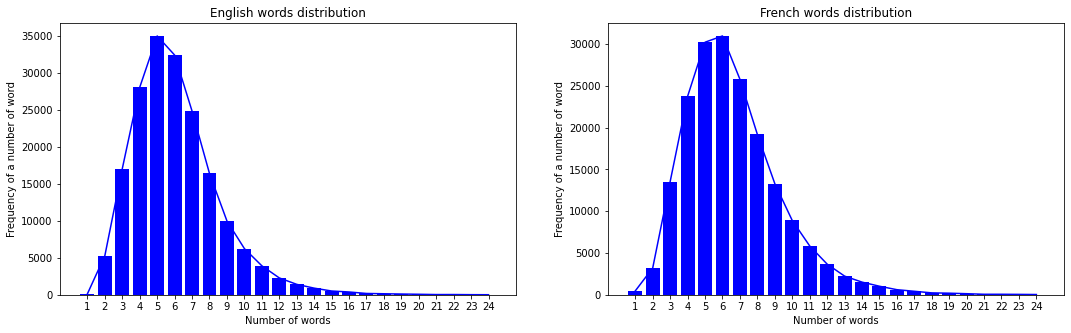

In [ ]:
from IPython.display import Markdown

display(Markdown("<h2 align='center'>Words count distribution</h2>", ))
visualize_frequency(df)

In [ ]:
display(Markdown("<h2 align='center'>Some random data</h2>", ))
display(df.sample(n=5, replace=True))

<h2 align='center'>Some random data</h2>

,english,french,eng_word_count,fr_word_count
34213,I sleep in the nude.,Je dors à poil.,5,4
84532,She especially likes music.,Elle aime particulièrement la musique.,4,5
3099,I was ready.,J'étais prête.,3,2
118671,Someone has stolen all my money.,Quelqu'un m'a volé tout mon argent.,6,6
55561,She picked me an apple.,Elle m'a cueilli une pomme.,5,5


# **Cleaning data**

In [ ]:
import re
import string

In [ ]:
def clean(text):
  """Clean the text"""
  removable_patterns = [
    "\[.*?\]", "\(.*?\)", "\{.*?\}", # Remove text within bracket
    "\d+",   # Remove numbers
  ]
  text = text.lower()
  for pattern in removable_patterns:
    text = re.sub(pattern, ' ', text)

  # Remove punctuations and some unwanted characters
  for p in f"{string.punctuation}»«…":
    text = text.replace(p, " ")

  # Remove whitespaces characters
  text = re.sub('\s+',' ', text)
  return text.strip()

# clean("now, when …I see an 18-year-old girl, my automatic thought…")

In [ ]:
df = df.drop(axis=1, columns=['eng_word_count', 'fr_word_count'])
df.english = df.english.apply(lambda s: clean(s))
df.french = df.french.apply(lambda s: clean(s))

## **Visualization after cleaning**

In [ ]:
display(df.sample(n=5))

,english,french
96034,how did you get here so fast,comment es tu arrivée ici si rapidement
131555,chocolate is toxic to many animals,le chocolat est toxique pour de nombreux animaux
22825,i really am sorry,je suis vraiment désolé
53688,i love being a teacher,j adore être enseignante
157505,what do you study a foreign language for,pourquoi apprends tu une langue étrangère


# **Preprocessing data for the training**

## **Preparing Train & Test Data**

In [ ]:
from time import localtime
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
def train_test_data(dataframe, train_size=9500):
  train_size = 9500
  dataframe = dataframe.sample(n=14000, random_state=localtime().tm_sec)
  train_set = dataframe[:train_size].reset_index(drop=True)
  test_set = dataframe[train_size:].reset_index(drop=True)
  return train_set, test_set

def tokenize(lines, maxlen, num_words=1500):
  tokenizer = Tokenizer(oov_token='UNK', num_words=num_words)
  tokenizer.fit_on_texts(lines)
  vocab_size = len(tokenizer.word_counts)+1
  sequences = tokenizer.texts_to_sequences(lines)
  
  sequences = pad_sequences(sequences, padding='post', maxlen=maxlen)
  return tokenizer, sequences

def max_len(lines): 
  return max(len(s.split()) for s in lines.to_numpy())

In [ ]:
train_set, test_set = train_test_data(df)
train_set.french = train_set.french.apply(lambda x: f'START {x} END')
test_set.french = train_set.french.apply(lambda x: f'START {x} END')

### **Processing encoder data**

In [ ]:
max_input_length =  max_len(train_set.english)
eng_tok, encoder_input_data = tokenize(train_set.english, max_input_length)
num_encoder_tokens = len(eng_tok.word_index)+1

### **Processing decoder data**

In [ ]:
from tensorflow.keras.utils import to_categorical

max_output_length =  max_len(train_set.french)
fr_tok, decoder_input_data = tokenize(train_set.french, max_output_length)
num_decoder_tokens = len(fr_tok.word_index)+1

# One hot-encoding the decoder target output data 
# decoder_target_data = to_categorical(decoder_input_data, num_classes=num_decoder_tokens)

# **Recurrent Neural Network**

## **Architecture**

In [ ]:
from tensorflow.keras.layers import Input, Embedding, GRU, TimeDistributed, Dense
from tensorflow.keras.models import Model

In [ ]:
# setting hyperparameters
embedding_size = 120
hsize = 324

### **Model for training**

In [ ]:
### Encoder
# Define an input layer which accepts a sequence of word IDs
encoder_inputs = Input(shape=(max_input_length,), name='encoder_train_input')
# Define an Embedding layer which accepts encoder_inputs
encoder_emb = Embedding(num_encoder_tokens, embedding_size, name='encoder_train_embedding')(encoder_inputs)
encoder_gru = GRU(hsize, return_state=True, name='encoder_train_gru')
encoder_outputs, en_state = encoder_gru(encoder_emb)

### Decoder
decoder_inputs = Input(shape=(max_output_length,), name='decoder_train_input')
# Define an Embedding layer which accepts decoder_inputs
decoder_emb = Embedding(num_decoder_tokens, embedding_size, name='decoder_train_embedding')(decoder_inputs)
decoder_gru = GRU(hsize, return_sequences=True, return_state=True, name='decoder_train_gru')
decoder_outputs, _ = decoder_gru(decoder_emb, initial_state=en_state)
decoder_dense = TimeDistributed(Dense(num_decoder_tokens, activation='softmax', name='decoder_train_dense'), name='decoder_train_td')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the Model which accepts encoder/decoder inputs and outputs predictions 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs, name='decoder_train_model')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
# hist = model.fit([encoder_input_data, decoder_input_data], decoder_target_data, epochs=10, batch_size=64, validation_split=0.2)

### **Model for prediction (Translation)**

In [ ]:
encoder_model = Model(encoder_inputs, en_state, name='encoder_predict')

decoder_state_inputs = Input(shape=(hsize,), name='decoder_predict_inp_state')
decoder_embeding = Embedding(num_decoder_tokens, embedding_size, name='decoder_pred_embedding')(decoder_inputs)

decoder_outputs2, state_2 = decoder_gru(decoder_embeding, initial_state=decoder_state_inputs)
decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model([decoder_inputs, decoder_state_inputs], [decoder_outputs2, state_2], name='decoder_predict')

In [ ]:
plot_model(decoder_model, show_shapes=True)

# **Generating Translation** 

In [ ]:
def decode_sequence(input_seq):
  states_values = encoder_model.predict(input_seq)

In [ ]:
np.zeros((1,1))

NameError: ignored

In [ ]:
def plot_one_history(x, y1, y2, input='loss', y1_label='Loss', y2_label='Validation loss', kind='plot'):
  
  title = "Loss's history"
  if input == 'acc':
    y1_label, y2_label = 'Accuracy', 'Validation Accuracy'
    title = "Accuracy's history"
  y_labl = y1_label

  labels=('Epochs', 'accuracy')
  if kind == 'scatter':
    plt.scatter(x, y1, label=y1_label)
    plt.scatter(x, y2, label=y2_label)
  else:
    plt.plot(x, y1, label=y1_label)
    plt.plot(x, y2, label=y2_label)
  
  plt.xlabel("Epochs", c='darkred')
  plt.ylabel(y_labl, c='darkblue')
  plt.title(title, c='darkgreen')
  plt.legend()

def plot_history(hist,name:str,figsize=(17, 5), kind='plot'):
  plt.figure(figsize=figsize)
  # Premier graphique : celle de gauche
  nb_epoch = range(1, len(hist.history['accuracy'])+1)
  plt.subplot(1, 2, 1)

  hist_acc = hist.history['accuracy']
  hist_val_acc = hist.history['val_accuracy']
  plot_one_history(x=nb_epoch, y1=hist_acc, y2=hist_val_acc, input='acc', kind=kind)

  # Seconde graphique : celle de droite
  plt.subplot(1,2,2)
  hist_loss     = hist.history['loss']
  hist_val_loss = hist.history['val_loss']
  plot_one_history(x=nb_epoch, y1=hist_loss, y2=hist_val_loss, input='loss', kind=kind)
  plt.show()

In [ ]:
# plot_history(hist, 'model_1.svg', kind='plot')

In [ ]:
# max_input_length =  max_len(train_set.english)
# eng_tok, encoder_input_data = tokenize(train_set.english, max_input_length)

encoder_test_data = eng_tok.texts_to_sequences(test_set.english)
encoder_test_data = pad_sequences(encoder_test_data, maxlen=max_input_length)
predict = model.predict(encoder_test_data)

In [ ]:
print(inspect.getsource(tokenize))